In [198]:
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from collections import Counter
import numpy as np
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from astropy.io import fits
from radio_beam import Beam
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

In [221]:
# zooiverse catalog
ACES_cat_path = '/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/aces_catalog_mv3_ms0.5_mp7_rms0.0001_min_peak0.0004_bl20_localrms2_globalrms3_tgif_fs1.0_2024_12_17_fullmask_0.6thresh_40perc.fits'
ACES_cat = Table.read(ACES_cat_path)

In [222]:
def get_spectral_index(data1, data2, freq1, freq2):
    #if (data1 == 999) | (data)
    return np.log(data1/data2)/np.log(freq1/freq2)

In [223]:
meerkat_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits')
meerkat = meerkat_hdul[0].data
wcs_meerkat = WCS(meerkat_hdul[0].header)

aces_reproj_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/cmz_sfr/12m_continuum_commonbeam_circular_reimaged_mosaic_convolved_with_meerkat.fits')
aces_reproj = aces_reproj_hdul[0].data
wcs_aces_reproj = WCS(aces_reproj_hdul[0].header)

In [224]:
i=478
x = ACES_cat[i]['x_peak']
y = ACES_cat[i]['y_peak']
#x, y = 5990, 1579
ACES_coord = SkyCoord(l = ACES_cat[i]['GLON']*u.deg, b = ACES_cat[i]['GLAT']*u.deg, frame='galactic')
x_meerkat, y_meerkat = ACES_coord.to_pixel(wcs_meerkat,)
x_meerkat = int(np.round(x_meerkat))
y_meerkat = int(np.round(y_meerkat))
pixel_value_meerkat = meerkat[y_meerkat][x_meerkat]
pixel_value_meerkat

np.float64(0.01807298110275884)

In [225]:
def background_subtraction_meerkat(x, y, annulus_r = 6, annulus_s = 10):
    extra_delta = 5  # Extra padding
    size = annulus_r + annulus_s + extra_delta

    cutout = meerkat[y-size:y+size+1, x-size:x+size+1]
    yy, xx = np.indices(cutout.shape)
    center = np.array(cutout.shape) // 2
    rr = np.sqrt((xx - center[1])**2 + (yy - center[0])**2)

    # annulus mask
    d_inner = annulus_r
    d_outer = annulus_r + annulus_s
    annulus = (rr > d_inner) & (rr < d_outer)


    annulus_values = cutout[annulus]

    mean = sigma_clip(annulus_values,sigma=5).mean()
    pixel_value_meerkat = meerkat[y][x]
    background_subtracted = pixel_value_meerkat - mean
    

    #plt.imshow(cutout, origin='lower', cmap='gray')
    #plt.contour(annulus, levels=[0.5], colors='red')
    #plt.show()
    return background_subtracted, mean

In [226]:
background_subtraction_meerkat(x_meerkat, y_meerkat)

(np.float64(0.017352001452111708), np.float64(0.0007209796506471351))

In [227]:
aces_freq = 100 * u.GHz
meerkat_freq = 1.284 * u.GHz
alphas_meerkat_aces = []
ACES_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
MEERKAT_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
ACES_RMS = 2.5e-4
MEERKAT_RMS = 2e-4
background_factor = 1.1
for i in range(len(ACES_cat)):
    x = ACES_cat[i]['x_peak']
    y = ACES_cat[i]['y_peak']
    ACES_coord = SkyCoord(l = ACES_cat[i]['GLON']*u.deg, b = ACES_cat[i]['GLAT']*u.deg, frame='galactic')
    x_meerkat, y_meerkat = ACES_coord.to_pixel(wcs_meerkat)
    x_meerkat = int(np.round(x_meerkat))
    y_meerkat = int(np.round(y_meerkat))
    pixel_value_meerkat = meerkat[y_meerkat][x_meerkat]

    pixel_value_meerkat_background_subtracted, background_value = background_subtraction_meerkat(x_meerkat, y_meerkat)
    # if aces_reproj[y][x] < ACES_RMS*5:
    #     ACES_5rms_mask[i] = True
    # Add another check to compare the background value and the peak value. If they are within 20%, it is a non detection
    # replace background subtraction with this approach. Only use the background subtraction to get the spectral index correctly.
    # Final note: do not spend any more time on this -- use Zooniverse information.
    if (pixel_value_meerkat_background_subtracted < MEERKAT_RMS*5) | (pixel_value_meerkat_background_subtracted > (background_value * background_factor)):
        MEERKAT_5rms_mask[i] = True
        pixel_value_meerkat_background_subtracted = MEERKAT_RMS*5
        
    

    alpha = get_spectral_index(aces_reproj[y][x], pixel_value_meerkat_background_subtracted, aces_freq, meerkat_freq)
    alphas_meerkat_aces.append(alpha)
alphas_meerkat_aces = np.array(alphas_meerkat_aces)

In [220]:
sum(MEERKAT_5rms_mask)

np.int64(1482)

In [195]:
# sum(MEERKAT_5rms_mask) used to be 1272

In [188]:
len(alphas_meerkat_aces)

1693

In [109]:
aces_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/12m_continuum_commonbeam_circular_reimaged_mosaic.fits')
aces = aces_hdul[0].data
wcs_aces = WCS(aces_hdul[0].header)
aces_beam = Beam.from_fits_header(aces_hdul[0].header)
cmzoom_hdul = fits.open('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/CMZoom_continuum_pbcor.fits')
cmzoom = cmzoom_hdul[0].data
wcs_cmzoom = WCS(cmzoom_hdul[0].header)

aces_jy_per_sr = aces / aces_beam.sr

In [228]:
aces_freq = 100 * u.GHz
cmzoom_freq = 225 * u.GHz
alphas_cmzoom_aces = []
#ACES_5rms_mask_CMZOOM = np.zeros(len(ACES_cat), dtype=bool)
CMZOOM_5rms_mask = np.zeros(len(ACES_cat), dtype=bool)
ACES_RMS = (2.5e-4 /(aces_beam.sr)).value
CMZOOM_RMS = 2 * 10**7
for i in range(len(ACES_cat)):
    x = ACES_cat[i]['x_peak']
    y = ACES_cat[i]['y_peak']
    ACES_coord = SkyCoord(l = ACES_cat[i]['GLON']*u.deg, b = ACES_cat[i]['GLAT']*u.deg, frame='galactic')
    x_cmzoom, y_cmzoom = ACES_coord.to_pixel(wcs_cmzoom)
    x_cmzoom = int(np.round(x_cmzoom))
    y_cmzoom = int(np.round(y_cmzoom))

    pixel_value_aces = aces_jy_per_sr[y][x].value
    try:
        pixel_value_cmzoom = cmzoom[y_cmzoom][x_cmzoom]
    except IndexError:
        pixel_value_cmzoom = np.nan
        #pixel_value_cmzoom = 999 # added this for now
    # if np.isnan(pixel_value_cmzoom):
    #     pixel_value_cmzoom = 999


    #if pixel_value_aces < ACES_RMS*5:
    #    ACES_5rms_mask_CMZOOM[i] = True
    if pixel_value_cmzoom < CMZOOM_RMS*5:
        CMZOOM_5rms_mask[i] = True
        pixel_value_cmzoom = CMZOOM_RMS*5
    # Need to check for nans, as the get skipped in the step above
    #if np.nan(pixel_value_cmzoom):
    #    CMZOOM_5rms_mask[i] = True


    alpha = get_spectral_index(pixel_value_aces, pixel_value_cmzoom, aces_freq, cmzoom_freq)
    alphas_cmzoom_aces.append(alpha.value)

alphas_cmzoom_aces = np.array(alphas_cmzoom_aces)

In [229]:
# SI_upper_limits = np.array(alphas_meerkat_aces)[ACES_5rms_mask]
# SI_lower_limits = np.array(alphas_meerkat_aces)[MEERKAT_5rms_mask]
# ACES_MEERKAT_5rms_mask = np.logical_or(ACES_5rms_mask, MEERKAT_5rms_mask)
# SI_above_5RMS = np.array(alphas_meerkat_aces)[~ACES_MEERKAT_5rms_mask]

#only_ACES_below_5RMS = ACES_5rms_mask & ~MEERKAT_5rms_mask  # ACES < 5σ, MEERKAT >= 5σ
only_MEERKAT_below_5RMS = MEERKAT_5rms_mask# & ~ACES_5rms_mask  # MEERKAT < 5σ, ACES >= 5σ
#ACES_MEERKAT_5rms_mask = ACES_5rms_mask | MEERKAT_5rms_mask  # Either one is below 5σ

# Apply masks
#SI_upper_limits = alphas_meerkat_aces[only_ACES_below_5RMS]  # Only ACES < 5σ
SI_lower_limits = alphas_meerkat_aces[only_MEERKAT_below_5RMS]  # Only MEERKAT < 5σ
SI_above_5RMS = alphas_meerkat_aces[~only_MEERKAT_below_5RMS]  # Neither below 5σ



#only_ACES_below_5RMS_cmzoom = CMZOOM_5rms_mask & ~ACES_5rms_mask_CMZOOM
only_CMZOOM_below_5RMS =  CMZOOM_5rms_mask
#both_below_5RMS_cmzoom = ACES_5rms_mask_CMZOOM | CMZOOM_5rms_mask

# Apply masks
#SI_lower_limits_cmzoom = alphas_cmzoom_aces[only_ACES_below_5RMS_cmzoom]  # 
SI_upper_limits_cmzoom = alphas_cmzoom_aces[only_CMZOOM_below_5RMS]  # 
SI_above_5RMS_cmzoom = alphas_cmzoom_aces[~only_CMZOOM_below_5RMS]  # 


In [230]:
ACES_cat.add_column(alphas_meerkat_aces, name='SI_meerkat_aces')
ACES_cat.add_column(only_MEERKAT_below_5RMS, name='meerkat_lower_limit?')
ACES_cat.add_column(alphas_cmzoom_aces, name='SI_cmzoom_aces')
ACES_cat.add_column(only_CMZOOM_below_5RMS, name='cmzoom_upper_limit?')

In [231]:
sum(np.isnan(ACES_cat['SI_cmzoom_aces']))

np.int64(1183)

In [211]:
sum(np.isnan(ACES_cat['SI_meerkat_aces']))

np.int64(0)

In [212]:
ACES_cat.write('aces_zooniverse_catalog_with_SI.fits', overwrite=True)

In [232]:
mask_both_above_5RMS = (~only_MEERKAT_below_5RMS) & (~only_CMZOOM_below_5RMS) & (~(np.isnan(ACES_cat['SI_cmzoom_aces'])))
mask_CMZOOM_upper_limit_only = only_CMZOOM_below_5RMS & (~only_MEERKAT_below_5RMS) & (~(np.isnan(ACES_cat['SI_cmzoom_aces'])))
mask_MEERKAT_lower_limit_only = only_MEERKAT_below_5RMS & (~only_CMZOOM_below_5RMS) & (~(np.isnan(ACES_cat['SI_cmzoom_aces'])))
mask_both_lower_limit = only_MEERKAT_below_5RMS & only_CMZOOM_below_5RMS & (~(np.isnan(ACES_cat['SI_cmzoom_aces'])))

In [233]:
sum(mask_both_lower_limit), sum(mask_CMZOOM_upper_limit_only), sum(mask_MEERKAT_lower_limit_only), sum(mask_both_above_5RMS)

(np.int64(410), np.int64(41), np.int64(55), np.int64(4))

In [234]:
sum(mask_both_lower_limit) +sum(mask_CMZOOM_upper_limit_only) + sum(mask_MEERKAT_lower_limit_only) + sum(mask_both_above_5RMS)

np.int64(510)

In [235]:
sum(mask_both_lower_limit), sum(mask_CMZOOM_upper_limit_only), sum(mask_MEERKAT_lower_limit_only), sum(mask_both_above_5RMS)

(np.int64(410), np.int64(41), np.int64(55), np.int64(4))

In [236]:
sum(mask_both_lower_limit) +sum(mask_CMZOOM_upper_limit_only) + sum(mask_MEERKAT_lower_limit_only) + sum(mask_both_above_5RMS)

np.int64(510)

In [121]:
ACES_cat_H40a = Table.read('aces_zooniverse_catalog_with_SI_with_H40a.fits')

In [123]:
H40a = ACES_cat_H40a['H40a detection']

In [138]:
sum(H40a)

np.int64(163)

In [143]:
sum(mask_both_lower_limit & H40a), sum(mask_CMZOOM_upper_limit_only & H40a), sum(mask_MEERKAT_lower_limit_only & H40a), sum(mask_both_above_5RMS & H40a)

(np.int64(64), np.int64(10), np.int64(33), np.int64(8))

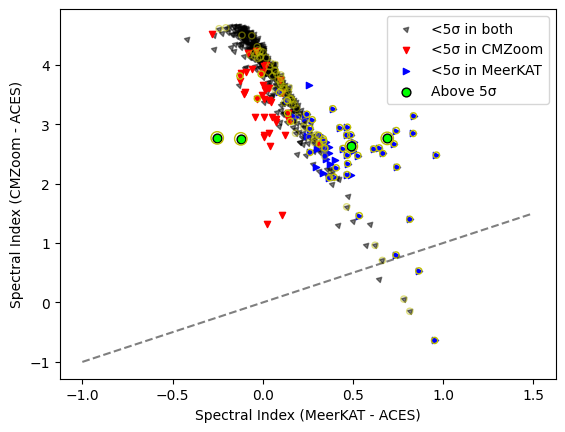

In [237]:
s = 20
plt.scatter(alphas_meerkat_aces[mask_both_lower_limit], alphas_cmzoom_aces[mask_both_lower_limit], marker = (3, 0, -45), c='k', alpha = 0.5, s=s, label = '<5σ in both')
plt.scatter(alphas_meerkat_aces[mask_CMZOOM_upper_limit_only], alphas_cmzoom_aces[mask_CMZOOM_upper_limit_only], marker = 'v', c='red', s=s, label = '<5σ in CMZoom')
plt.scatter(alphas_meerkat_aces[mask_MEERKAT_lower_limit_only], alphas_cmzoom_aces[mask_MEERKAT_lower_limit_only], marker = '>', c='blue', s=s, label = '<5σ in MeerKAT')
plt.scatter(alphas_meerkat_aces[mask_both_above_5RMS], alphas_cmzoom_aces[mask_both_above_5RMS], c='lime',ec ='k', s=s+20, label = 'Above 5σ')

plt.scatter(alphas_meerkat_aces[mask_both_lower_limit & H40a], alphas_cmzoom_aces[mask_both_lower_limit & H40a], marker = 'o', c='none', ec='y', alpha = 0.5, s=s)
plt.scatter(alphas_meerkat_aces[mask_CMZOOM_upper_limit_only & H40a], alphas_cmzoom_aces[mask_CMZOOM_upper_limit_only & H40a], marker = 'o', c='none', ec='y', s=s)
plt.scatter(alphas_meerkat_aces[mask_MEERKAT_lower_limit_only & H40a], alphas_cmzoom_aces[mask_MEERKAT_lower_limit_only & H40a], marker = 'o', c='none', ec='y', s=s)
plt.scatter(alphas_meerkat_aces[mask_both_above_5RMS & H40a], alphas_cmzoom_aces[mask_both_above_5RMS & H40a], marker = 'o', c='none', ec ='y', s=s+60)


plt.legend()
plt.xlabel('Spectral Index (MeerKAT - ACES)')
plt.ylabel('Spectral Index (CMZoom - ACES)')
#plt.xlim(-1, 1.5)
#plt.ylim(-1, 5)
#plt.plot([0,1], [0,1], color = 'k', linestyle = '--')
# plt.plot([-1,0], [0,0], color = 'k', linestyle = '--', alpha = 0.5)
# plt.plot([0,0], [-1,0], color = 'k', linestyle = '--', alpha = 0.5)
# plt.plot([-1,1], [1,1], color = 'k', linestyle = '--', alpha = 0.5)
# plt.plot([1,1], [-1,1], color = 'k', linestyle = '--', alpha = 0.5)
x_ = np.linspace(-1, 1.5, 100)
plt.plot(x_, x_, color = 'k', linestyle = '--', alpha = 0.5)
#plt.savefig('/Users/nbudaiev/UFL Dropbox/Nazar Budaiev/Research/ACES/figures/SI_meerkat_cmzoom_aces.png', dpi = 300, bbox_inches='tight')

(-1.0, 1.5)

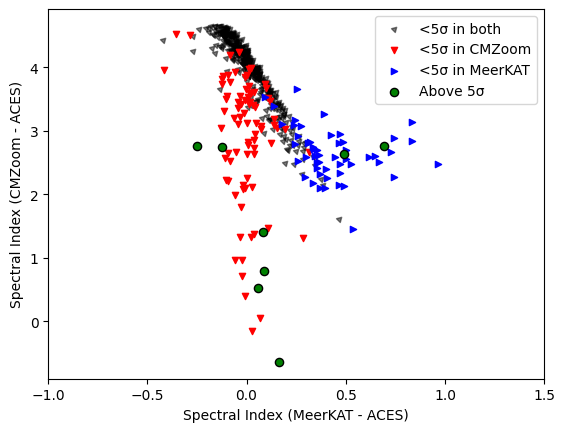

In [118]:
s = 20
plt.scatter(alphas_meerkat_aces[mask_both_lower_limit], alphas_cmzoom_aces[mask_both_lower_limit], marker = (3, 0, -45), c='k', alpha = 0.5, s=s, label = '<5σ in both')
plt.scatter(alphas_meerkat_aces[mask_CMZOOM_upper_limit_only], alphas_cmzoom_aces[mask_CMZOOM_upper_limit_only], marker = 'v', c='red', s=s, label = '<5σ in CMZoom')
plt.scatter(alphas_meerkat_aces[mask_MEERKAT_lower_limit_only], alphas_cmzoom_aces[mask_MEERKAT_lower_limit_only], marker = '>', c='blue', s=s, label = '<5σ in MeerKAT')
plt.scatter(alphas_meerkat_aces[mask_both_above_5RMS], alphas_cmzoom_aces[mask_both_above_5RMS], c='green',ec ='k', s=s+15, label = 'Above 5σ')
plt.legend()
plt.xlabel('Spectral Index (MeerKAT - ACES)')
plt.ylabel('Spectral Index (CMZoom - ACES)')
plt.xlim(-1, 1.5)

(0.0002, 0.2)

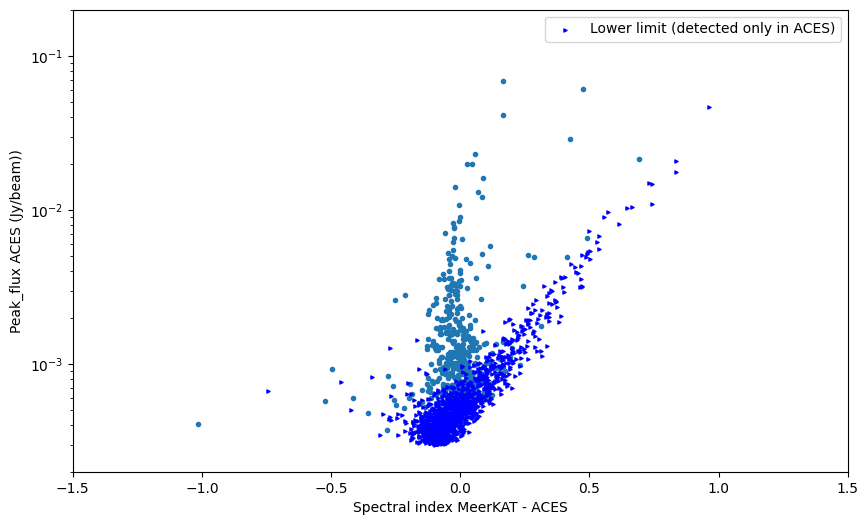

In [48]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS, ACES_cat['peak_flux'][~only_MEERKAT_below_5RMS], marker = '.')
plt.scatter(SI_lower_limits, ACES_cat['peak_flux'][only_MEERKAT_below_5RMS], marker = '>', color = 'b', label = 'Lower limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(0.0002,0.2)

(0.0002, 0.2)

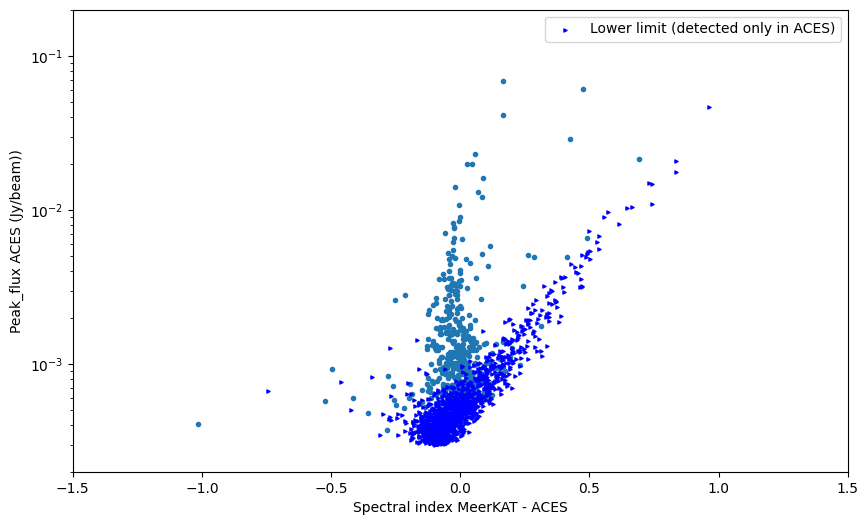

In [49]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS, ACES_cat['peak_flux'][~only_MEERKAT_below_5RMS], marker = '.')
plt.scatter(SI_lower_limits, ACES_cat['peak_flux'][only_MEERKAT_below_5RMS], marker = '>', color = 'b', label = 'Lower limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index MeerKAT - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(0.0002,0.2)

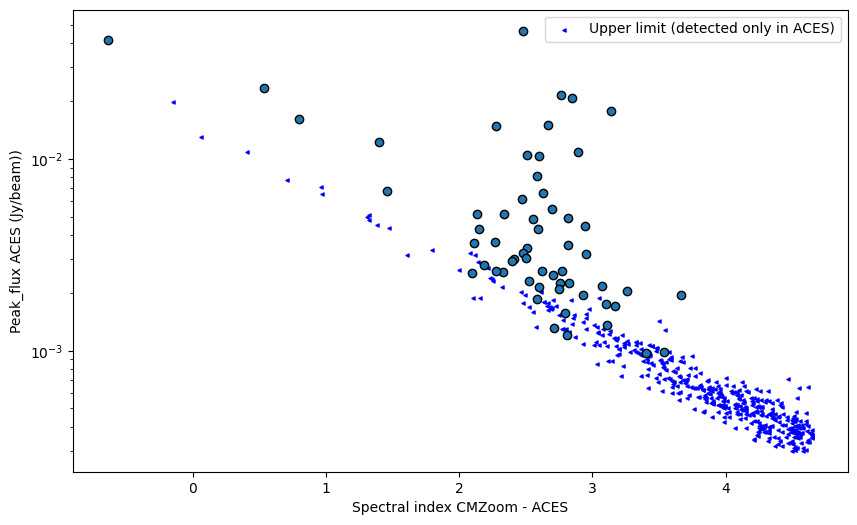

In [50]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_upper_limits_cmzoom, ACES_cat['peak_flux'][only_CMZOOM_below_5RMS], marker = '<', color = 'b', label = 'Upper limit (detected only in ACES)', s =5)
plt.scatter(SI_above_5RMS_cmzoom, ACES_cat['peak_flux'][~only_CMZOOM_below_5RMS], marker = 'o', ec = 'k')

plt.yscale('log')
plt.xlabel('Spectral index CMZoom - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
#plt.xlim(-1.5,1.5)
#plt.ylim(0.0002,0.2)

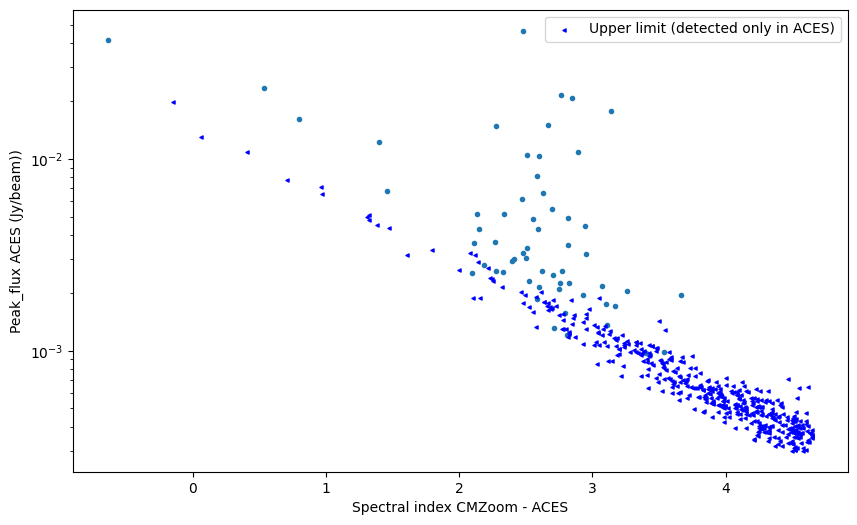

In [51]:
plt.figure(figsize=(10, 6))
#plt.scatter(alphas_meerkat_aces, ACES_cat['peak_flux'], marker = '.')
plt.scatter(SI_above_5RMS_cmzoom, ACES_cat['peak_flux'][~only_CMZOOM_below_5RMS], marker = '.')
plt.scatter(SI_upper_limits_cmzoom, ACES_cat['peak_flux'][only_CMZOOM_below_5RMS], marker = '<', color = 'b', label = 'Upper limit (detected only in ACES)', s =5)
plt.yscale('log')
plt.xlabel('Spectral index CMZoom - ACES')
plt.ylabel('Peak_flux ACES (Jy/beam))')
plt.legend()
#plt.xlim(-1.5,1.5)
#plt.ylim(0.0002,0.2)